In [10]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import mean_absolute_error
# from sklearn.model_selection import train_test_split
# from keras.callbacks import EarlyStopping

In [2]:
import yfinance as yf

Stk = yf.Ticker("SPY")
df = Stk.history(start='2016-01-01')
df.reset_index(level=0, inplace=True)
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2015-12-31,185.031928,185.717460,183.895370,183.895370,114877900,0.0,0
1,2016-01-04,180.846545,181.333631,179.132693,181.324615,222353500,0.0,0
2,2016-01-05,181.667361,182.118373,180.449639,181.631287,110845800,0.0,0
3,2016-01-06,178.907168,180.458648,178.239680,179.340149,152112600,0.0,0
4,2016-01-07,176.192125,178.095394,174.622600,175.037537,213436100,0.0,0
...,...,...,...,...,...,...,...,...
1380,2021-06-25,425.899994,427.089996,425.549988,426.609985,58129500,0.0,0
1381,2021-06-28,427.170013,427.649994,425.890015,427.470001,53159600,0.0,0
1382,2021-06-29,427.880005,428.559998,427.130005,427.700012,35970500,0.0,0
1383,2021-06-30,427.209991,428.779999,427.179993,428.059998,64827900,0.0,0


In [3]:
training_set = df.iloc[:, 1:2].values
# test_set = df.iloc[800:, 1:2].values

In [4]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [5]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
training_set_scaled = np.reshape(training_set_scaled,len(training_set_scaled))
print(training_set_scaled)

X_train, y_train = split_sequence(training_set_scaled, 60)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_train.shape, y_train.shape

[0.07775155 0.06192152 0.06502603 ... 0.99625564 0.99372151 1.        ]


((1325, 60, 1), (1325,))

In [11]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences=True, input_shape = (60,1)))
# model.add(Dropout(0.2))
# # Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
# model.add(Dropout(0.2))
# # Adding a third LSTM layer and some Dropout regularisation
# model.add(LSTM(units = 50))
# model.add(Dropout(0.2))
# # Adding a fourth LSTM layer and some Dropout regularisation
# model.add(LSTM(units = 50))
# model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mse', metrics=[mean_absolute_error])

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 150, batch_size=32)


Epoch 1/150
42/42 [==============================] - 13s 58ms/step - loss: 0.0641 - mean_absolute_error: 0.1769
Epoch 2/150
42/42 [==============================] - 2s 58ms/step - loss: 0.0015 - mean_absolute_error: 0.0278
Epoch 3/150
42/42 [==============================] - 3s 60ms/step - loss: 8.1752e-04 - mean_absolute_error: 0.0180
Epoch 4/150
42/42 [==============================] - 3s 65ms/step - loss: 9.1142e-04 - mean_absolute_error: 0.0182
Epoch 5/150
42/42 [==============================] - 2s 56ms/step - loss: 7.0868e-04 - mean_absolute_error: 0.0167
Epoch 6/150
42/42 [==============================] - 2s 55ms/step - loss: 6.7219e-04 - mean_absolute_error: 0.0169
Epoch 7/150
42/42 [==============================] - 2s 54ms/step - loss: 5.5489e-04 - mean_absolute_error: 0.0156
Epoch 8/150
42/42 [==============================] - 3s 60ms/step - loss: 6.5212e-04 - mean_absolute_error: 0.0164
Epoch 9/150
42/42 [==============================] - 2s 57ms/step - loss: 6.9700e-04 - 

In [12]:
def X_input(inputs):
    inputs = sc.fit_transform(inputs)
    inputs = np.array(inputs)
    inputs = np.reshape(inputs,(1,60,1))
    return inputs
input1 = df.iloc[len(df)-60:len(df), 1:2].values
Xinputs = X_input(input1)

[[430.42999268]
 [428.81564331]
 [428.44091797]
 [427.99685669]]


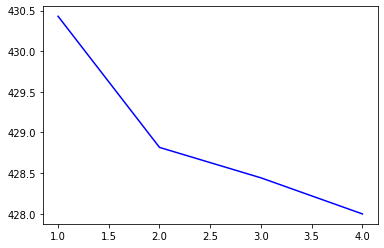

In [13]:
pred_price_lst = []
for i in range(3):
    x_price = df.iloc[len(df)-60+i:len(df), 1:2].values
    if pred_price_lst:
        x_price = np.append(x_price, np.concatenate(pred_price_lst, axis=0), axis=0)
    x_price = X_input(x_price)
    pred_price_i = model.predict(x_price)
    pred_price_i = sc.inverse_transform(pred_price_i)
    pred_price_lst.append(pred_price_i)
pred_price_lst = np.concatenate(pred_price_lst, axis=0)
pred_price_lst = np.concatenate([[df.iloc[len(df)-1:]['Close'].values],pred_price_lst], axis=0)
print(pred_price_lst)
plt.plot([x for x in range(1,4+1)],np.concatenate(pred_price_lst, axis=0), color = 'blue', label = 'Predicted')

In [14]:
diff = np.diff(pred_price_lst.reshape(1,-1)[0])
diff

array([-1.61434937, -0.37472534, -0.44406128])

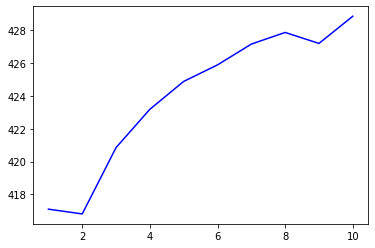

In [15]:
actprice = df.iloc[len(df)-10:, 1:2].values
plt.plot([x for x in range(1,11)],np.concatenate(actprice, axis=0), color = 'blue', label = 'Actual')